In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [2]:
train_df = pd.read_csv('../training.csv') # split for test and train set is ready
test = pd.read_csv('../test.csv')

# 1. Splitting the data

In [3]:
df = train_df

y = df["IsBadBuy"]
X = df

del X["IsBadBuy"]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = pd.DataFrame(X_train.join(y_train))
val = X_val.join(y_val)

In [5]:
y_train.value_counts()

0    44805
1     6283
Name: IsBadBuy, dtype: int64

In [6]:
val.head()

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
10580,10589,5/11/2010,MANHEIM,2004,6,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,BLUE,...,8885.0,NaN,NaN,18822,77041,TX,5685.0,0,569,0
27667,27686,4/22/2009,MANHEIM,2006,3,CHRYSLER,PACIFICA AWD 3.5L V6,Bas,4D SPORT,GOLD,...,11956.0,NaN,NaN,5546,32824,FL,6645.0,0,1857,0
60595,60624,9/16/2010,MANHEIM,2002,8,FORD,ESCAPE 2WD V6,XLS,4D CUV 3.0L XLS,GREEN,...,7897.0,NaN,NaN,23359,92337,CA,5480.0,0,1353,0
60484,60513,2/13/2009,ADESA,2005,4,DODGE,DURANGO 4WD V8 SEFI,SLT,4D SUV 5.7L SLT,RED,...,13878.0,NaN,NaN,23359,91752,CA,8375.0,0,1763,0
48363,48387,2/4/2010,MANHEIM,2006,4,PONTIAC,MONTANA FWD,SV6,4D MINIVAN EXT 3.5L,GOLD,...,14091.0,NaN,NaN,18111,47129,IN,6475.0,0,2282,0


In [7]:
train.columns

Index(['RefId', 'PurchDate', 'Auction', 'VehYear', 'VehicleAge', 'Make',
       'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID',
       'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost', 'IsBadBuy'],
      dtype='object')

In [8]:
train.groupby("Color")["IsBadBuy"].agg(["mean","count"]) # wygląda na to ze not avaiable color zwiększa szanse zlego zakupu, zas pomaranczowy kolor w dziwny sposob zmniejsza - ale jest tam dosyc malo danych

,mean,count
Color,,
BEIGE,0.139706,1088
BLACK,0.113936,5389
BLUE,0.115784,7229
BROWN,0.132890,301
GOLD,0.142626,3702
GREEN,0.118362,2222
GREY,0.116101,5478
MAROON,0.135135,1443
NOT AVAIL,0.253731,67


In [9]:
# na razie damy tylko kolumne czy jest bardziej niebezpieczna czy nie

color_train = train.groupby("Color")["IsBadBuy"].agg(["mean"]) 

max_mean_color = color_train["mean"].max()
color_dict = color_train["mean"].to_dict()
train["ColorDanger"] = train["Color"].map(color_dict).fillna(train.IsBadBuy.mean())/max_mean_color
bad_colors = list(color_train.loc[color_train["mean"] > train.IsBadBuy.mean()].index)

train['DangerousColor'] = np.where(train["Color"].isin(bad_colors), 1, 0)

przygotowanie imputacji

In [10]:
# zaimputujemy sobie wartość 0 dla kolumn MMRCurrentAuctionAveragePrice oraz MMRAcquisitionAuctionAveragePrice
# pozostałe wywalamy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train["MMRCurrentAuctionAveragePrice"] = np.where(train["MMRCurrentAuctionAveragePrice"] == 0, np.nan, train["MMRCurrentAuctionAveragePrice"])
train["MMRAcquisitionAuctionAveragePrice"] = np.where(train["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, train["MMRAcquisitionAuctionAveragePrice"])

imp_mean = IterativeImputer(random_state=0)

MMR_columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]

imp_mean.fit(train[MMR_columns])

MMR_train_transformed = imp_mean.transform(train[MMR_columns])
MMR_train_transformed = pd.DataFrame(MMR_train_transformed, columns = MMR_columns)
MMR_train_transformed.index = train.index
MMR_train_transformed

c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,MMRCurrentAuctionAveragePrice,MMRAcquisitionAuctionAveragePrice,VehBCost
51596,6473.0,5602.0,6800.0
7358,8975.0,7038.0,10775.0
66010,6680.0,6680.0,6890.0
39674,6416.0,5820.0,6870.0
12486,5978.0,4836.0,7350.0
...,...,...,...
22569,8529.0,8168.0,6470.0
41811,3769.0,3720.0,5935.0
67791,6346.0,5560.0,7130.0
40656,5345.0,5512.0,8370.0


In [11]:
train_df

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,73010,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,WHITE,...,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974


In [12]:
def gini_train_val(model, X_train, y_train, X_val, y_val):
    
    y_pred_proba = model.predict_proba(X_train)[::,1]
    gini_train = gini_roc(y_train, y_pred_proba, "ROC Curve for Training Sample")
    print("gini_train: %.4f" % gini_train)
    
    y_pred_proba = model.predict_proba(X_val)[::,1]
    gini_val = gini_roc(y_val, y_pred_proba, "Roc Curve for Validation Sample")
    print("gini_val: %.4f" % gini_val)

## OVERSAMPLING

In [84]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

In [85]:
x_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [86]:
X_train.shape

(51088, 99)

In [87]:
x_train_resampled.shape

(89610, 99)

In [88]:
y_train.value_counts()

0    44805
1     6283
Name: IsBadBuy, dtype: int64

In [89]:
y_train_resampled.value_counts()

0    44805
1    44805
Name: IsBadBuy, dtype: int64

# 2. Preparing functions for pipeline

In [19]:
train_df = pd.read_csv('../training.csv') # split for test and train set is ready
test = pd.read_csv('../test.csv')

y = train_df["IsBadBuy"]
X = train_df.drop('IsBadBuy', axis=1)

In [20]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    X['WheelTypeID'] = X['WheelTypeID'].fillna(1)
    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
        
    return X

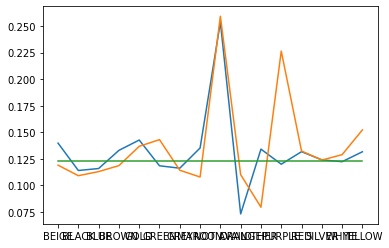

In [21]:
train_bad_buy_mean = train.IsBadBuy.mean()

color_val = val.groupby("Color")["IsBadBuy"].agg(["mean"])
color = color_val.join(color_train, lsuffix="_val", rsuffix="_train")
color["mean"] = train.IsBadBuy.mean()
plt.plot(color.index, color["mean_train"])
plt.plot(color.index, color["mean_val"])
plt.plot(color.index, color["mean"])

plt.show()

In [22]:
def encode_categorical(df):
    df["ColorDanger"] = df["Color"].map(color_dict).fillna(train_bad_buy_mean)/max_mean_color # no takie w miare to jest średnie
    #df['DangerousColor'] = np.where(df["Color"].isin(bad_colors), 1, 0)

    df["IsPrimeunitNA"] = np.where(df["PRIMEUNIT"].isna(), 1, 0) # to moze byc niepotrzebne
    primeunit_dict = {'NO':0, 'YES':1, float("nan"):0} # nie jestem pewien czy nie lepiej bedzie zamienic na odwrot
    df['PRIMEUNIT'] = df['PRIMEUNIT'].str.upper().map(primeunit_dict)
    aucguart_dict = {'GREEN':2, 'YELLOW':1, "RED":0, float("nan"):0}
    df['AUCGUART'] = df['AUCGUART'].str.upper().map(aucguart_dict)

    transmission_dict = {'AUTO':0, 'MANUAL':1}
    df['Transmission'] = df['Transmission'].str.upper().map(transmission_dict)
    df["Transmission"] = df["Transmission"].fillna(df["Transmission"].median())

    df = df.drop(columns=["BYRNO", "Color"])

    print("Categorical columns transformed.")

    return df

def impute_MMR(df):

    # zamieniamy 0 na nan    
    df["MMRCurrentAuctionAveragePrice"] = np.where(df["MMRCurrentAuctionAveragePrice"] == 0, np.nan, df["MMRCurrentAuctionAveragePrice"])
    df["MMRAcquisitionAuctionAveragePrice"] = np.where(df["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, df["MMRAcquisitionAuctionAveragePrice"])

    MMR_df = imp_mean.transform(df[MMR_columns])
    MMR_df = pd.DataFrame(MMR_df, columns = MMR_columns)
    MMR_df.index = df.index
    df["MMRCurrentAuctionAveragePrice"] = MMR_df["MMRCurrentAuctionAveragePrice"]
    df["MMRAcquisitionAuctionAveragePrice"] = MMR_df["MMRAcquisitionAuctionAveragePrice"]

    df = df.drop(columns = ["MMRAcquisitionAuctionCleanPrice", "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice", 
                            "MMRCurrentAuctionCleanPrice", "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice"]) 
    
    # tutaj moze tez MMRAcquisitionAuctionAveragePrice

    print("MMR Columns imputed.")
    return df

In [23]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    #X = X[X['WheelTypeID'].notna()] TAK NIE WOLNO - to nam psuje preprocessing
    X['WheelTypeID'] = X['TopThreeAmericanName'].fillna(0)

    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
    
    return X

In [24]:
def assign_chassis(df):

    types = ["CAB", "CONVERTIBLE", "CUV", "HATCHBACK", "PASSENGER", "SEDAN", "SPORT", "SUV", "MINIVAN", "UTILITY", "WAGON"]

    for word in df['SubModel_splited']:
        if word in types:
            return word
    return "OTHER"

def assign_season(df):

    if 3 <= df['Month'] <= 5: val = 'Spring'
    elif 6 <= df['Month'] <= 8: val = 'Summer'
    elif 9 <= df['Month'] <= 11: val = 'Autumn'
    else: val = 'Winter'

    return val

def preprocess(df):

    df['PurchDate'] = pd.to_datetime(df['PurchDate'])
    df['Month'] = df['PurchDate'].dt.month
    df['Year'] = df['PurchDate'].dt.year.apply(lambda x: x == 2010).astype(int)
    df['Season'] = df.apply(assign_season, axis = 1)
    df['Doors'] = df['SubModel'].str.extract(r'([1-9]D)').replace(np.nan, "UNKNOWN")
    df['SubModel_splited'] = df['SubModel'].apply(lambda x: str(x).split())
    df['Chassis'] = df.apply(assign_chassis, axis=1)

    print("Done preprocessing")

    return df

# 3. Making pipeline

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = X_train.join(y_train)
val = X_val.join(y_val)

In [26]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_val: {X_val.shape}')

Shape of X_train: (51088, 33)
Shape of X_val: (21895, 33)


In [27]:
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of y_train: (51088,)
Shape of y_val: (21895,)


In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['VehOdo','VehBCost', 'WarrantyCost']),
        ('cat', OneHotEncoder(sparse_output=False),  ['TopThreeAmericanName', 'WheelTypeID','Nationality','Size',
                                                      'Make', 'Chassis', 'Doors', 'Auction', 'Season', 'Month']),
        ('passthrough','passthrough', ['IsOnlineSale', 'VehicleAge', 'Year'])
    ])

In [29]:
categorical_transformer = FunctionTransformer(encode_categorical)
MMR_imputer = FunctionTransformer(impute_MMR)
mateusz_transformer = FunctionTransformer(preprocess_df)
maciej_transformer = FunctionTransformer(preprocess)

# all the afore declared processings applied
prepipe = Pipeline([
    ("transform_categorical", categorical_transformer),
    ("MMR_imputing", MMR_imputer), 
    ("Mateusz", mateusz_transformer),
    ("Maciej", maciej_transformer)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [30]:
X_train = prepipe.fit_transform(X_train)
some_colnames = X_train.columns
X_train = pipeline.fit_transform(X_train)

Categorical columns transformed.
MMR Columns imputed.
Done preprocessing


In [31]:
X_train

array([[ 0.90092155,  0.03974257,  1.02045083, ...,  0.        ,
         5.        ,  0.        ],
       [ 0.61199229,  2.29599753,  0.22244171, ...,  0.        ,
         6.        ,  0.        ],
       [ 0.0953035 ,  0.09082759, -0.79169488, ...,  0.        ,
         3.        ,  0.        ],
       ...,
       [-1.77211927,  0.22705431, -1.32536349, ...,  0.        ,
         2.        ,  1.        ],
       [-0.36213357,  0.93089233, -0.0934369 , ...,  0.        ,
         7.        ,  0.        ],
       [-1.03397285, -1.0330428 ,  1.14181472, ...,  0.        ,
         8.        ,  1.        ]])

In [32]:
# validation dataset

X_val = prepipe.transform(X_val)
X_val = pipeline.transform(X_val)


Categorical columns transformed.
MMR Columns imputed.
Done preprocessing


# 4. XGboost

In [98]:
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [99]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [100]:
acc_train_xg = round(xgb_classifier.score(X_train, y_train) * 100, 2)
acc_test_xg = round(xgb_classifier.score(X_val, y_val) * 100, 2)
roc_test_xg = round(roc_auc_score(y_val, xgb_classifier.predict_proba(X_val)[:, 1]),3)
print('XGboost train accurary: ',acc_train_xg)
print('XGboost test accurary: ',acc_test_xg)
print('XGboost test ROC: ',roc_test_xg)

XGboost train accurary:  88.75
XGboost test accurary:  87.54
XGboost test ROC:  0.653


In [101]:
y_pred = xgb_classifier.predict(X_val)

In [102]:
print(confusion_matrix(y_val, y_pred))

[[19102   100]
 [ 2629    64]]


# Tuning XGboost

In [103]:
param_dist = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.3],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0],
              'gamma': [0, 1, 5]}

In [104]:
xgb_clf = xgb.XGBClassifier()

In [105]:
rand_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=10, cv=3)


In [106]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.5, 0.8, 1.0]})

In [107]:
rand_search.best_params_

{'subsample': 1.0,
 'n_estimators': 50,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 5,
 'colsample_bytree': 1.0}

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Best XGboost

In [109]:
rand_search.best_score_

0.8773880396837462

In [110]:
best_xgb_clf = xgb.XGBClassifier(n_estimators=rand_search.best_params_['n_estimators'],
                                 max_depth=rand_search.best_params_['max_depth'],
                                 learning_rate=rand_search.best_params_['learning_rate'],
                                 subsample=rand_search.best_params_['subsample'],
                                 colsample_bytree=rand_search.best_params_['colsample_bytree'],
                                 gamma=rand_search.best_params_['gamma'])

In [111]:
best_xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [112]:
acc_train_xg = round(best_xgb_clf.score(X_train, y_train) * 100, 2)
acc_test_xg = round(best_xgb_clf.score(X_val, y_val) * 100, 2)
roc_test_xg = round(roc_auc_score(y_val, best_xgb_clf.predict_proba(X_val)[:, 1]),3)
print('XGboost train accurary: ',acc_train_xg)
print('XGboost test accurary: ',acc_test_xg)
print('XGboost test ROC: ',roc_test_xg)

XGboost train accurary:  87.77
XGboost test accurary:  87.7
XGboost test ROC:  0.669


In [113]:
y_pred = xgb_classifier.predict(X_val)

In [114]:
print(confusion_matrix(y_val, y_pred)) # niby najlepszy a slabo wyszlo

[[19102   100]
 [ 2629    64]]


<Figure size 432x288 with 0 Axes>

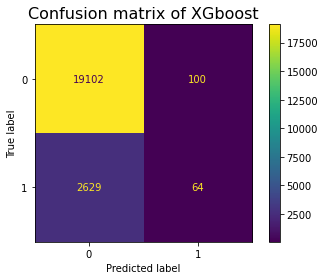

In [116]:
fig = plt.figure()
cm = confusion_matrix(y_val, y_pred, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_classifier.classes_)
disp.plot()
plt.title('Confusion matrix of XGboost', fontsize = 16)
plt.show()

In [117]:
fig = plt.figure()
cm = confusion_matrix(y_val, y_pred, labels=xgb_classifier.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_classifier.classes_)
plt.show()

<Figure size 432x288 with 0 Axes>

In [118]:
from sklearn import metrics

In [119]:
def gini_roc(y_test, y_pred_proba, tytul):
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    plt.plot(fpr,tpr)
    plt.title(tytul)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    roc_auc = metrics.auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    return gini

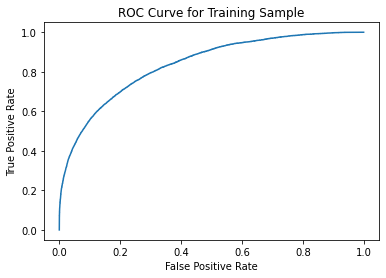

gini_train: 0.6734


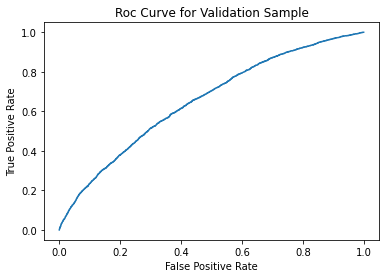

gini_val: 0.3057


In [120]:
gini_train_val(xgb_classifier, X_train, y_train, X_val, y_val)

In [78]:
classification_report(y_val,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.88      0.99      0.93     19202\n           1       0.39      0.02      0.04      2693\n\n    accuracy                           0.88     21895\n   macro avg       0.63      0.51      0.49     21895\nweighted avg       0.82      0.88      0.82     21895\n'

In [79]:
print('              precision    recall  f1-score   support\n\n           0       0.88      0.99      0.93     19202\n           1       0.39      0.02      0.04      2693\n\n    accuracy                           0.88     21895\n   macro avg       0.63      0.51      0.49     21895\nweighted avg       0.82      0.88      0.82     21895\n')

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     19202
           1       0.39      0.02      0.04      2693

    accuracy                           0.88     21895
   macro avg       0.63      0.51      0.49     21895
weighted avg       0.82      0.88      0.82     21895



## Model with oversampling

In [90]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_resampled,y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [91]:
acc_train_xg = round(xgb_classifier.score(x_train_resampled, y_train_resampled) * 100, 2)
acc_test_xg = round(xgb_classifier.score(X_val, y_val) * 100, 2)
roc_test_xg = round(roc_auc_score(y_val, xgb_classifier.predict_proba(X_val)[:, 1]),3)
print('XGboost train accurary: ',acc_train_xg)
print('XGboost test accurary: ',acc_test_xg)
print('XGboost test ROC: ',roc_test_xg)

XGboost train accurary:  78.12
XGboost test accurary:  68.35
XGboost test ROC:  0.643


In [92]:
y_pred = xgb_classifier.predict(X_val)
print(confusion_matrix(y_val, y_pred))

[[13665  5537]
 [ 1393  1300]]


<Figure size 432x288 with 0 Axes>

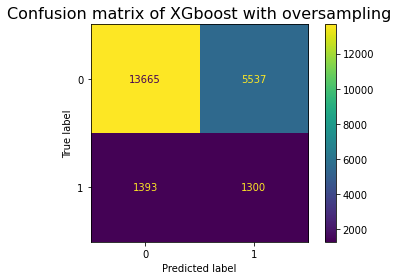

In [95]:
fig = plt.figure()
cm = confusion_matrix(y_val, y_pred, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_classifier.classes_)
disp.plot()
plt.title('Confusion matrix of XGboost with oversampling', fontsize = 16)
plt.show()

# Tuning

In [62]:
param_dist = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.3],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0],
              'gamma': [0, 1, 5]}

In [81]:
xgb_clf = xgb.XGBClassifier()

In [82]:
rand_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=10, cv=3)

In [83]:
rand_search.fit(x_train_resampled, y_train_resampled)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py", line 908, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py", line 743, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py", line 970, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py", line 417, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py", line 391, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "c:\users\uzytkownik\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py", line 283, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:PurchDate: object, Auction: object, Make: object, Model: object, Trim: object, SubModel: object, Color: object, Transmission: object, WheelType: object, Nationality: object, Size: object, TopThreeAmericanName: object, PRIMEUNIT: object, AUCGUART: object, VNST: object


In [66]:
rand_search.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'max_depth': 7,
 'learning_rate': 0.3,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [67]:
rand_search.best_score_

0.7875013949336012

In [68]:
best_xgb_clf = xgb.XGBClassifier(n_estimators=rand_search.best_params_['n_estimators'],
                                 max_depth=rand_search.best_params_['max_depth'],
                                 learning_rate=rand_search.best_params_['learning_rate'],
                                 subsample=rand_search.best_params_['subsample'],
                                 colsample_bytree=rand_search.best_params_['colsample_bytree'],
                                 gamma=rand_search.best_params_['gamma'])

In [70]:
best_xgb_clf.fit(x_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [71]:
acc_train_xg = round(xgb_classifier.score(x_train_resampled, y_train_resampled) * 100, 2)
acc_test_xg = round(xgb_classifier.score(X_val, y_val) * 100, 2)
roc_test_xg = round(roc_auc_score(y_val, xgb_classifier.predict_proba(X_val)[:, 1]),3)
print('XGboost train accurary: ',acc_train_xg)
print('XGboost test accurary: ',acc_test_xg)
print('XGboost test ROC: ',roc_test_xg)

XGboost train accurary:  78.12
XGboost test accurary:  68.35
XGboost test ROC:  0.643


In [72]:
y_pred = xgb_classifier.predict(X_val)
print(confusion_matrix(y_val, y_pred))

[[13665  5537]
 [ 1393  1300]]


# Final outputs

In [45]:
test = pd.read_csv('../test.csv')

In [46]:
X_test = test.copy()
X_test

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,73015,12/2/2009,ADESA,2005,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,SILVER,...,8557.0,9752.0,NaN,NaN,18881,30212,GA,6500.0,0,2152
1,73016,12/2/2009,ADESA,2005,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,...,7562.0,9296.0,NaN,NaN,18111,30212,GA,6300.0,0,1118
2,73017,12/2/2009,ADESA,2006,3,DODGE,DURANGO 2WD V8,Adv,4D SUV 4.7L ADVENTURER,SILVER,...,15340.0,16512.0,NaN,NaN,18111,30212,GA,9700.0,0,1215
3,73018,12/2/2009,ADESA,2002,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,...,5725.0,6398.0,NaN,NaN,18881,30212,GA,4150.0,0,1933
4,73019,12/2/2009,ADESA,2007,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,...,5914.0,7350.0,NaN,NaN,18111,30212,GA,4100.0,0,920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,121742,11/17/2010,MANHEIM,2005,5,FORD,FIVE HUNDRED,SEL,4D SEDAN SEL,BLACK,...,9764.0,11395.0,NaN,NaN,20928,33411,FL,7955.0,0,1633
48703,121743,11/17/2010,MANHEIM,2007,3,TOYOTA,COROLLA,CE,4D SEDAN CE,GREEN,...,10283.0,11565.0,NaN,NaN,20928,33411,FL,7035.0,0,594
48704,121744,11/17/2010,MANHEIM,2006,4,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,...,7871.0,9490.0,NO,GREEN,20928,33411,FL,6335.0,0,594
48705,121745,11/17/2010,MANHEIM,2005,5,MAZDA,MAZDA3,s,4D SEDAN GT,SILVER,...,8576.0,9937.0,NO,GREEN,20928,33411,FL,8055.0,0,1038


In [47]:
X_test = prepipe.transform(X_test)
X_test = pipeline.transform(X_test)

Categorical columns transformed.
MMR Columns imputed.
Done preprocessing


In [48]:
y = xgb_classifier.predict(X_test)
pd.DataFrame(y, columns=["IsBadBuy"]).join(test["RefId"]).to_csv("../out.csv", index=False)